In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
pip install -r /content/drive/MyDrive/Colab_Notebooks/node/requirements.txt

  Using cached https://github.com/facebookresearch/qhoptim/archive/master.zip
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done


In [ ]:
%load_ext autoreload
%autoreload 2
%env CUDA_VISIBLE_DEVICES=0,1
import os, sys
import time
import pandas as pd
from datetime import datetime
sys.path.insert(0, '..')
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from content.drive.MyDrive.Colab_Notebooks.node import lib
import torch, torch.nn as nn
import torch.nn.functional as F

device = 'cuda' if torch.cuda.is_available() else 'cpu'

experiment_name = 'year_node_shallow'
experiment_name = '{}_{}.{:0>2d}.{:0>2d}_{:0>2d}:{:0>2d}'.format(experiment_name, *time.gmtime()[:5])
print("experiment:", experiment_name)

In [ ]:
print(device)

In [ ]:
def create_output(predictions):
    """
    Function that creates output csv submission file. Returns the submission dataframe.
    Input:
    - predictions: an array with shape (n_predictions, 1) with the ARRIVAL_DELAY outputs (ordered).
    Return:
    - submission: dataframe with id and ARRIVAL_DELAY fields.
    """
    submission = pd.DataFrame(data={"id": np.arange(len(predictions)),
                                    "ARRIVAL_DELAY": np.reshape(predictions, (len(predictions)))})
    filename = f"{datetime.now().strftime('%Y_%m_%d-%I_%M_%S_%p')}.csv"
    submission.to_csv(filename, index=False)
    return submission

In [ ]:
data = lib.Dataset("FLIGHT_DELAYS", random_state=1337, data_path="/content/drive/MyDrive/Colab_Notebooks/node/notebooks/data",quantile_transform=False, quantile_noise=1e-3)
in_features = data.X_train.shape[1]

mu, std = data.y_train.mean(), data.y_train.std()
normalize = lambda x: ((x - mu) / std).astype(np.float32)
data.y_train, data.y_valid = map(normalize, [data.y_train.values.astype('float32'), data.y_valid.values.astype('float32')])

print("mean = %.5f, std = %.5f" % (mu, std))

In [5]:
class EncodedNODES(nn.Module):
    def __init__(self, in_features, num_trees, num_layers=8, tree_dim=3, depth=6, flatten_output=False,
                   choice_function=lib.entmax15, bin_function=lib.entmoid15):
        super(EncodedNODES, self).__init__()
        self.fcn = nn.Sequential(
            nn.Linear(in_features, 128),
            nn.ReLU(True),
            nn.Linear(128, 256),
            nn.ReLU(True),
            nn.Linear(256, 128),
            nn.ReLU(True),
            nn.Linear(128, 64),
            nn.ReLU(True),
            nn.Linear(64, 32),
            nn.ReLU(True),
            nn.Linear(32, 16),
            nn.ReLU(True),
            nn.Linear(16, 1),
            nn.Sigmoid()).to(device)
        '''
        self.NODE =  nn.Sequential(
            lib.DenseBlock(256, 128, num_layers=3, tree_dim=4, depth=3, flatten_output=False,
                           choice_function=lib.entmax15, bin_function=lib.entmoid15),
            lib.Lambda(lambda x: x[..., 0].mean(dim=-1)),  # average first channels of every tree
        ).to(device)'''

    def forward(self, input):
        assert len(input.shape) >= 2
        if len(input.shape) > 2:
            return self.forward(input.view(-1, input.shape[-1])).view(*input.shape[:-1], -1)
        out = self.fcn(input)
        #normalized = nn.functional.normalize(coded)
        #out = self.NODE(normalized)
        return out

In [ ]:
model = nn.Sequential(
    lib.DenseBlock(in_features, 150, num_layers=2, tree_dim=4, depth=5, flatten_output=False,
                   choice_function=lib.entmax15, bin_function=lib.entmoid15),
    lib.Lambda(lambda x: x[..., 0].mean(dim=-1)),  # average first channels of every tree
    
).to(device)


#model = EncodedNODES(in_features, num_trees=64, num_layers=8, tree_dim=5, depth=6, flatten_output=False,
#                   choice_function=lib.entmax15, bin_function=lib.entmoid15)

with torch.no_grad():
    res = model(torch.as_tensor(data.X_train[:1000], device=device))
    # trigger data-aware init
    
if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)

In [8]:
from qhoptim.pyt import QHAdam
optimizer_params = { 'nus':(0.7, 1.0), 'betas':(0.95, 0.998)}

In [9]:
trainer = lib.Trainer(
    model=model, loss_function=F.mse_loss,
    experiment_name=experiment_name,
    warm_start=False,
    Optimizer=QHAdam,
    optimizer_params=optimizer_params,
    verbose=True,
    n_last_checkpoints=5
)

In [10]:
from tqdm import tqdm
from IPython.display import clear_output
loss_history, mse_history = [], []
best_mse = float('inf')
best_step_mse = 0
early_stopping_rounds = 5000
report_frequency = 5000

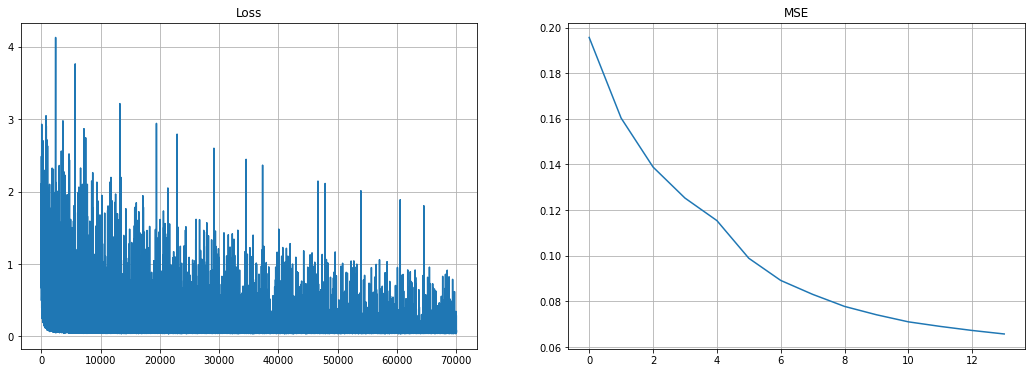

Loss 0.28045
Val MSE: 0.06570


KeyboardInterrupt: ignored

In [11]:
for batch in lib.iterate_minibatches(data.X_train, data.y_train, batch_size=512, 
                                                shuffle=True, epochs=float('inf')):
    metrics = trainer.train_on_batch(*batch, device=device)
    
    loss_history.append(metrics['loss'])

    if trainer.step % report_frequency == 0:
        trainer.save_checkpoint()
        trainer.average_checkpoints(out_tag='avg')
        trainer.load_checkpoint(tag='avg')
        mse = trainer.evaluate_mse(
            data.X_valid, data.y_valid, device=device, batch_size=1024)

        if mse < best_mse:
            best_mse = mse
            best_step_mse = trainer.step
            trainer.save_checkpoint(tag='best_mse')
        mse_history.append(mse)
        
        trainer.load_checkpoint()  # last
        trainer.remove_old_temp_checkpoints()

        clear_output(True)
        plt.figure(figsize=[18, 6])
        plt.subplot(1, 2, 1)
        plt.plot(loss_history)
        plt.title('Loss')
        plt.grid()
        plt.subplot(1, 2, 2)
        plt.plot(mse_history)
        plt.title('MSE')
        plt.grid()
        plt.show()
        print("Loss %.5f" % (metrics['loss']))
        print("Val MSE: %0.5f" % (mse))
    if trainer.step > best_step_mse + early_stopping_rounds:
        print('BREAK. There is no improvement for {} steps'.format(early_stopping_rounds))
        print("Best step: ", best_step_mse)
        print("Best Val MSE: %0.5f" % (best_mse))
        break

In [12]:
trainer.load_checkpoint(tag='best_mse')
# Evaluate On Validation Data
mse = trainer.evaluate_mse(data.X_valid, data.y_valid, device=device, batch_size=256)
print('Best step: ', trainer.step)
print("Test MSE: %0.5f" % (mse))

Loaded logs/year_node_shallow_2021.12.19_14:43/checkpoint_best_mse.pth
Best step:  70000
Test MSE: 0.06570


In [13]:
mse * std ** 2

108.42542696388551

In [14]:
model.train(False)
X_test = torch.as_tensor(data.X_test, device=device)
with torch.no_grad():
    predictions = lib.utils.process_in_chunks(model, X_test, batch_size=256)
    predictions = lib.utils.check_numpy(predictions)

In [15]:
X_test.shape

torch.Size([514383, 14])

In [16]:
data.X_train.shape

(2677625, 14)

In [17]:
# Dnormalize Predictions
dnorm_predictions = predictions*std+mu

In [17]:
create_output(dnorm_predictions[:,np.newaxis])

,id,ARRIVAL_DELAY
0,0,26.392374
1,1,-11.703245
2,2,5.304423
3,3,41.398666
4,4,11.416903
...,...,...
514379,514379,-8.632923
514380,514380,3.368196
514381,514381,-4.864650
514382,514382,4.598313
